In [1]:
%matplotlib inline

import random 
import torch
from d2l import torch as d2l

### Linear Regression step by step

#### Make Synthetic Data

In [24]:
def synthetic_data(w, b, num_examples):
    """y = Xw + b + noise"""
    X = torch.normal(0, 1, (num_examples, len(w)))  # mean = 0, variance = 1
    y = torch.matmul(X, w) + b                     # matrix multiply
    y += torch.normal(0, 0.01, y.shape)           # random noise
    return X, y.reshape((-1,1))

In [25]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

#### Show the format of result

In [26]:
print('features:', features[0], 
      '\nlablel:', labels[0])

features: tensor([0.0947, 0.8373]) 
lablel: tensor([1.5478])


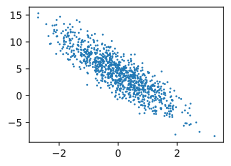

In [27]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(),
                labels.detach().numpy(), 1);    # In some pytorch version, First do .detach(), Then do .numpy()

#### Read the Dataset

In [28]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # shuffle all the indices
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i : min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [29]:
batch_size = 10 

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.0551,  0.0401],
        [-0.1416,  0.8239],
        [-1.0421,  0.8258],
        [ 0.6958,  0.9449],
        [-0.3100, -1.6240],
        [ 1.2814, -0.3879],
        [-0.1215, -2.0840],
        [ 0.8167,  0.2226],
        [ 1.2006,  1.2509],
        [ 0.5294, -0.1463]]) 
 tensor([[ 4.1829],
        [ 1.1150],
        [-0.7107],
        [ 2.3934],
        [ 9.0927],
        [ 8.0743],
        [11.0255],
        [ 5.0787],
        [ 2.3414],
        [ 5.7682]])


#### Initialize Model Parameters

In [30]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

#### Define the Model——Linear Model

In [31]:
def linreg(X, w, b):  # linear regression
    return torch.matmul(X, w) + b

#### Define the Loss Function——Squared Error

In [32]:
def squared_loss(y_hat, y):  # squared error
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

#### Define the Optimization Algorithm——Stochastic Gradient Descent 

In [33]:
def sgd(params, lr, batch_size):  # mini batch stochastic gradient descent 
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

#### Start training

In [34]:
lr = 0.001  # cannot be too large
num_epoch = 10
net = linreg
loss = squared_loss

In [36]:
for epoch in range(num_epoch):  # for loop 1: read all data
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():                               # gradient will not be tracked
        train_loss = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_loss.mean()):f}')

epoch 1, loss 1.942392
epoch 2, loss 1.606693
epoch 3, loss 1.329078
epoch 4, loss 1.099489
epoch 5, loss 0.909605
epoch 6, loss 0.752555
epoch 7, loss 0.622651
epoch 8, loss 0.515198
epoch 9, loss 0.426313
epoch 10, loss 0.352778


In [14]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([ 0.7207, -1.3130], grad_fn=<SubBackward0>)
error in estimating b: tensor([1.5989], grad_fn=<RsubBackward1>)


### Linear Regression easily from PyTorch

#### Read the Dataset

In [15]:
from torch.utils import data

In [16]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [17]:
def load_array(data_arrays, batch_size, is_train=True):
    """Create a PyTorch iterator"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [18]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)
it = iter(data_iter)
next(it)

[tensor([[ 0.0093, -1.0388],
         [ 0.1081, -1.2332],
         [-0.6223,  1.8142],
         [ 0.2917,  0.2500],
         [ 0.2156,  0.5427],
         [-0.6001, -1.0461],
         [-0.1483,  1.9085],
         [ 0.7114,  0.4999],
         [-0.0786, -0.2961],
         [-0.7215, -0.6040]]),
 tensor([[ 7.7324],
         [ 8.5962],
         [-3.2093],
         [ 3.9164],
         [ 2.7961],
         [ 6.5564],
         [-2.5676],
         [ 3.9273],
         [ 5.0751],
         [ 4.8116]])]

#### Define the Model——Linear Model

In [19]:
from torch import nn

net = nn.Sequential(nn.Linear(2,1))

#### Intialize Model Parameters

In [20]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

#### Define the Loss Function——Mean Squared Error

In [21]:
loss = nn.MSELoss()

#### Define the Optimization Algorithm——SGD

In [22]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [23]:
num_epochs = 3

for epoch in range(num_epochs):
    for X, y, in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()            # PyTorch has done 'sum' for us
        trainer.step()          # .step to update the model
    l = loss(net(features), labels)
    print(f'epoch {epoch+1}, loss {l:f}')

epoch 1, loss 0.000224
epoch 2, loss 0.000101
epoch 3, loss 0.000101
